In [2]:
import os
import geopandas as gpd
from osgeo import gdal, ogr, osr
import numpy as np
import rasterio
from rasterio.mask import mask
from shapely.geometry import Polygon, MultiPolygon, shape
from shapely.ops import unary_union
import pandas as pd
import seaborn as sns
import json
from matplotlib.transforms import Bbox
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Required File Doc
input_raster = "../USGS_Raster/raw_raster/L2SP_013032_20250416_20250418.TIF"
clip_geojson = "../USGS_Raster/Borough.geojson"
clipped_raster = "../USGS_Raster/nyc_raster/20250416.tif"

# 04/16/2025 As an Example Data Processing

## Clip the input raster to the geographic extent of NYC

In [208]:
# Read the Raster Data
with rasterio.open(input_raster) as src:
    gdf_clip = gpd.read_file(clip_geojson)
    gdf_clip = gdf_clip.to_crs(src.crs)  # Project gdf_clip using the same crs as the raster data

    # Clip the raster
    clipped_image, clipped_transform = mask(src, gdf_clip.geometry, crop=True)
    clipped_meta = src.meta.copy()
    clipped_meta.update({
        "driver": "GTiff",
        "height": clipped_image.shape[1],
        "width": clipped_image.shape[2],
        "transform": clipped_transform,
        "dtype": "float32",
        "nodata": -9999.0
    })

# Write the clipped raster data into clipped_raster
os.makedirs(os.path.dirname(clipped_raster), exist_ok=True)
with rasterio.open(clipped_raster, "w", **clipped_meta) as dest:
    dest.write(np.where(np.isnan(clipped_image), -9999.0, clipped_image))

## Polygonize the raster at the pixel level and convert the result into a GeoDataFrame

Each Pixel is a 30m * 30m Square in real life.

In [209]:
# Open the clipped raster and get the first band
src_ds = gdal.Open(clipped_raster)
band = src_ds.GetRasterBand(1)

# Create an in-memory vector datasource to store polygonized features
mem_driver = ogr.GetDriverByName("Memory")
mem_ds = mem_driver.CreateDataSource("memData")

# Use the same spatial reference as the raster
srs = osr.SpatialReference()
srs.ImportFromWkt(src_ds.GetProjection())

# Create a layer and add a field to store the raster values
layer = mem_ds.CreateLayer("layer", srs=srs)
field = ogr.FieldDefn("value", ogr.OFTReal)
layer.CreateField(field)

# Polygonize the raster band and store the result in the memory layer
gdal.Polygonize(band, None, layer, 0, [], callback=None)

# Convert the in-memory OGR layer to a Geodataframe
features = []
# Iterate over each polygonized feature from the raster
for feat in layer:
    # Convert the geometry from JSON string to a shapely geometry object
    geom_json = json.loads(feat.GetGeometryRef().ExportToJson())
    geom = shape(geom_json)

    # Extract the raster value from the feature (e.g., pixel value)
    value = feat.GetField("value")

    # Only keep valid features with non-null and non-negative values
    if value is not None and value >= 0:
        features.append({
            "geometry": geom,
            "value": value
        })

# Convert the feature list into a GeoDataFrame
gdf = gpd.GeoDataFrame(features, crs=f"EPSG:{raster_epsg}")

## Compute Temperature

In [210]:
# Convert pixel DN value to temperature in Kelvin using a predefined formula
gdf["temperature_K"] = gdf["value"] * 0.00341802 + 149.0

# Convert temperature from Kelvin to Fahrenheit
gdf["temperature_F"] = (gdf["temperature_K"] - 273.15) * 9 / 5 + 32

# Clean the Noise Data that has a temperature lower than -20F
gdf = gdf[gdf['temperature_F'] >= -20]

# Preview the resulting data
gdf.head()

geometry    value  temperature_K  \
0  POLYGON ((591735 4529925, 591735 4529895, 5917...  38169.0     279.462405   
1  POLYGON ((591765 4529925, 591765 4529895, 5917...  38299.0     279.906748   
2  POLYGON ((591795 4529925, 591795 4529895, 5918...  38469.0     280.487811   
3  POLYGON ((591825 4529925, 591825 4529895, 5918...  38582.0     280.874048   
4  POLYGON ((591735 4529895, 591735 4529865, 5917...  38198.0     279.561528   

   temperature_F  
0      43.362330  
1      44.162146  
2      45.208060  
3      45.903286  
4      43.540750

## Visualization Making

<Axes: xlabel='temperature_F', ylabel='Count'>

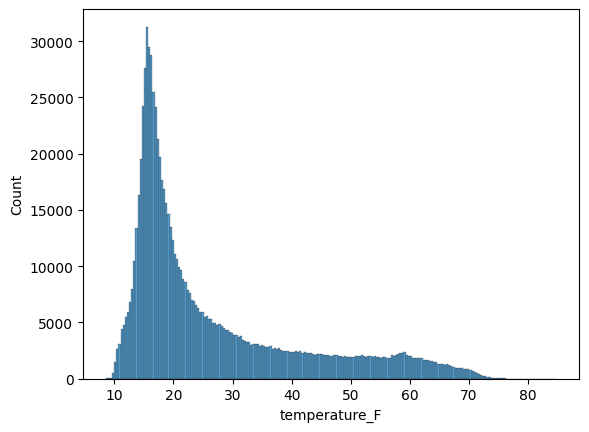

In [211]:
gdf.to_file('../USGS_Raster/Temp_data/temp_pixel.geojson', driver="GeoJSON")
sns.histplot(gdf['temperature_F'])

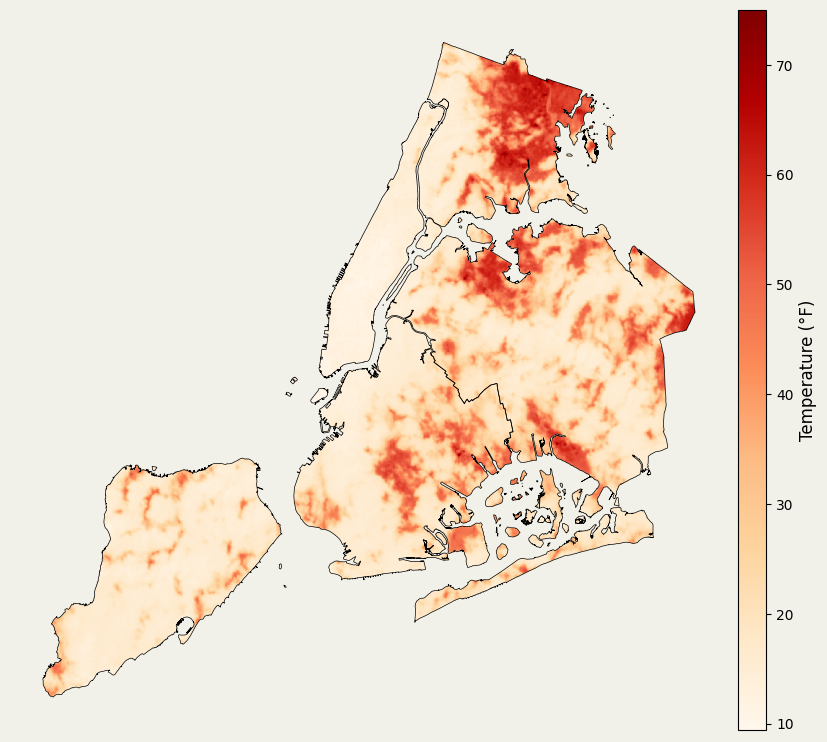

In [233]:
boundary_gdf = gpd.read_file("../USGS_Raster/Borough.geojson")
boundary_gdf = boundary_gdf.to_crs(gdf.crs)
boundary_gdf = boundary_gdf.buffer(0)

fig, ax = plt.subplots(figsize=(15, 9))
plot = gdf.plot(
    column='temperature_F',
    cmap='OrRd',
    ax=ax,
    legend=False, 
    edgecolor='none'
)

boundary_gdf.boundary.plot(
    ax=ax,
    color='black',
    linewidth=0.5
)

ax.axis('off')
ax.set_position([0.1, 0.1, 0.75, 0.8])  # left, bottom, width, height

# Legend / ColorBar Design
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="4%", pad=0.1)
sm = plt.cm.ScalarMappable(cmap='OrRd', norm=plt.Normalize(
    vmin=gdf_result['temperature_F'].min(),
    vmax=gdf_result['temperature_F'].max()
))
sm._A = []
cbar = fig.colorbar(sm, cax=cax)
cbar.set_label("Temperature (°F)", fontsize=12)


fig.patch.set_facecolor('#F1F0E9')
fig.savefig('../USGS_Raster/Example_Pic/pic_pixel.png', dpi=300, facecolor='#F1F0E9')
plt.show()


## Census Block Level Temperature Data

In [223]:
gdf_blocks = gpd.read_file("../USGS_Raster/Block_nowater.geojson")
gdf_blocks = gdf_blocks.to_crs(gdf.crs)


# Perform a spatial intersection between pixels and census blocks
# This will clip each pixel polygon to the boundaries of the census blocks
gdf_intersect = gpd.overlay(gdf, gdf_blocks, how="intersection")


# Calculate area for each intersected polygon
# This area will be used for weighted averaging
gdf_intersect["area"] = gdf_intersect.geometry.area


# Compute area-weighted temperature
# Multiply temperature by area to get weighted value
gdf_intersect["weighted_temp"] = gdf_intersect["temperature_F"] * gdf_intersect["area"]

# Group by census block ID and sum weighted values and area
block_avg_temp = (
    gdf_intersect.groupby("geoid")[["weighted_temp", "area"]]
    .sum()
    .reset_index()
)

# Compute area-weighted average temperature for each block
block_avg_temp["temperature_F"] = block_avg_temp["weighted_temp"] / block_avg_temp["area"]

# Keep only necessary columns
block_avg_temp = block_avg_temp[["geoid", "temperature_F"]]

# Join the aggregated results back to the census block geometries
gdf_result = gdf_blocks.merge(block_avg_temp, on="geoid", how="left")
gdf_result.to_file("../USGS_Raster/Temp_data/temp_block.geojson", driver="GeoJSON")
gdf_result.head()


shape_area     shape_leng   boroname  ct2020 borocode cb2020  \
0  1202838.17013  6437.85374521  Manhattan  000100        1   1000   
1  640166.352288  4395.19018343  Manhattan  000100        1   1001   
2  129276.332277   1569.3848232  Manhattan  000201        1   1000   
3  139360.445114  1594.26285534  Manhattan  000201        1   1001   
4   263308.43936  2055.29596105  Manhattan  000201        1   2000   

     bctcb2020            geoid  \
0  10001001000  360610001001000   
1  10001001001  360610001001001   
2  10002011000  360610002011000   
3  10002011001  360610002011001   
4  10002012000  360610002012000   

                                            geometry  temperature_F  
0  MULTIPOLYGON (((581106.119 4505997.085, 581148...      13.166790  
1  MULTIPOLYGON (((580787.267 4504805.375, 580819...      11.189412  
2  MULTIPOLYGON (((585722.289 4507480.709, 585558...      13.022846  
3  MULTIPOLYGON (((585727.959 4507402.057, 585695...      12.679246  
4  MULTIPOLYGON (((585737.948 4507321.994, 585747...      13.091170

<Axes: xlabel='temperature_F', ylabel='Count'>

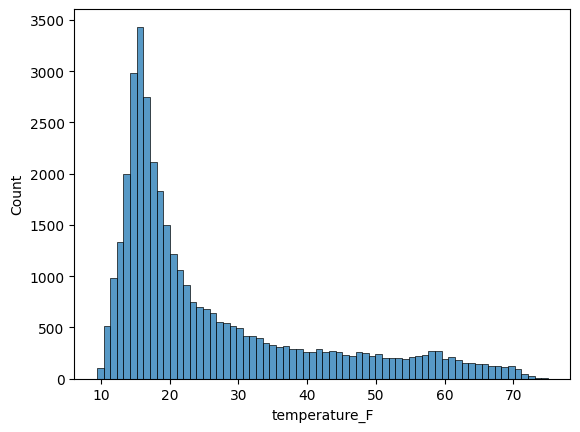

In [216]:
sns.histplot(gdf_result['temperature_F'])

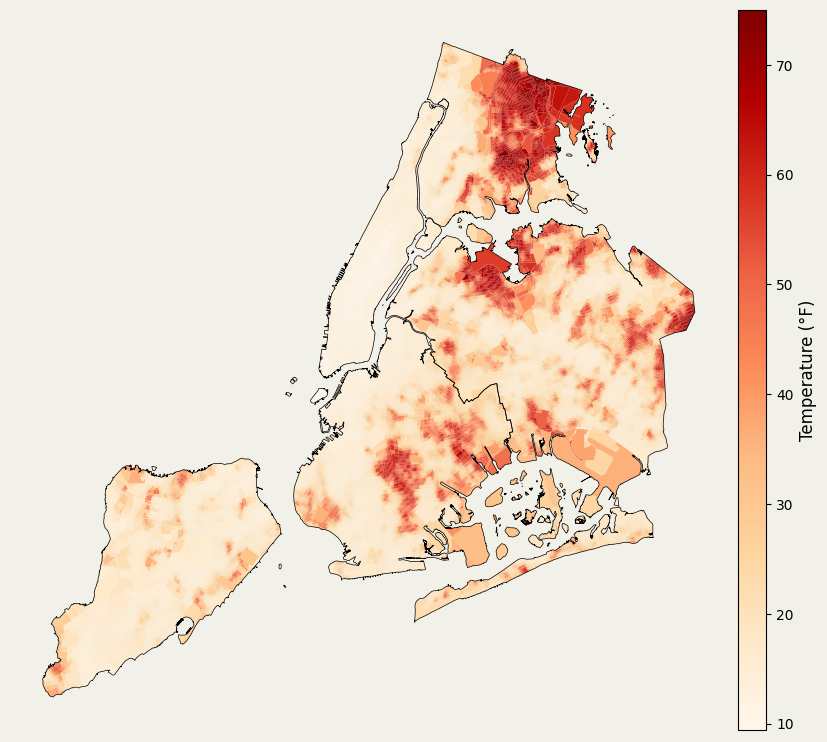

In [234]:
boundary_gdf = gpd.read_file("../USGS_Raster/Borough.geojson")
boundary_gdf = boundary_gdf.to_crs(gdf_result.crs)
boundary_gdf = boundary_gdf.buffer(0)


fig, ax = plt.subplots(figsize=(15, 9))
plot = gdf_result.plot(
    column='temperature_F',
    cmap='OrRd',
    ax=ax,
    legend=False,
    edgecolor='none'
)
boundary_gdf.boundary.plot(
    ax=ax,
    color='black',
    linewidth=0.5
)

ax.axis('off')
ax.set_position([0.1, 0.1, 0.75, 0.8])  # left, bottom, width, height

# ColorBar/Legend Design
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="4%", pad=0.1)
sm = plt.cm.ScalarMappable(cmap='OrRd', norm=plt.Normalize(
    vmin=gdf_result['temperature_F'].min(),
    vmax=gdf_result['temperature_F'].max()
))
sm._A = []  
cbar = fig.colorbar(sm, cax=cax)
cbar.set_label("Temperature (°F)", fontsize=12)

fig.patch.set_facecolor('#F1F0E9') 
fig.savefig('../USGS_Raster/Example_Pic/pic_block.png', dpi=300, facecolor='#F1F0E9')
plt.show()


# Reproducing

In [5]:
import os
import json
import numpy as np
import geopandas as gpd
import rasterio
from rasterio.mask import mask
from rasterstats import zonal_stats

# Required File Doc
raster_path = "../USGS_Raster/"
clip_geojson = "../USGS_Raster/Borough.geojson"
block_path = raster_path + "Block.geojson"
output_folder = raster_path + "Temp_data/"

file_name = ["L2SP_20250323",'L2SP_20250110','L2SP_20241107',
             'L2SP_20241006','L2SP_20240827','L2SP_20240702',
             'L2SP_20240507','L2SP_20240225','L2SP_20231215',
             'L2SP_20231028','L2SP_20230606','L2SP_20250408']
gdf_blocks = gpd.read_file(block_path)

for i in file_name:
    input_raster = raster_path + 'raw_raster/' + i + '.TIF'
    clipped_raster = raster_path + 'nyc_raster/' + i[5:] + '.TIF'

    # Clip the raster to NYC boundary
    with rasterio.open(input_raster) as src:
        gdf_clip = gpd.read_file(clip_geojson)
        gdf_clip = gdf_clip.to_crs(src.crs)
        nyc_geom = gdf_clip.geometry.values

        clipped_image, clipped_transform = mask(src, nyc_geom, crop=True)
        clipped_meta = src.meta.copy()
        clipped_meta.update({
            "driver": "GTiff",
            "height": clipped_image.shape[1],
            "width": clipped_image.shape[2],
            "transform": clipped_transform,
            "dtype": "float32",
            "nodata": -9999.0
        })

    # Save the clipped raster
    os.makedirs(os.path.dirname(clipped_raster), exist_ok=True)
    with rasterio.open(clipped_raster, "w", **clipped_meta) as dest:
        dest.write(np.where(np.isnan(clipped_image), -9999.0, clipped_image))

    # Open the clipped raster and ensure CRS matches
    with rasterio.open(clipped_raster) as src:
        raster_crs = src.crs

    gdf_blocks = gdf_blocks.to_crs(raster_crs)

    # Perform zonal statistics to extract mean temperature for each block
    stats = zonal_stats(
        gdf_blocks, 
        clipped_raster, 
        stats=["mean"],
        nodata=-9999.0
    )

    # Attach the mean temperature back to the blocks
    gdf_blocks['raw_temperature'] = [item['mean'] for item in stats]
    gdf_blocks.dropna(subset=['raw_temperature'], inplace=True)
    
    # Convert DN to temperature in Kelvin
    gdf_blocks["temperature_K"] = gdf_blocks["raw_temperature"] * 0.00341802 + 149.0

    # Convert temperature from Kelvin to Fahrenheit
    gdf_blocks["temperature_F"] = (gdf_blocks["temperature_K"] - 273.15) * 9 / 5 + 32

    # Filter out noise (temperature below -20°F)
    gdf_blocks = gdf_blocks[gdf_blocks['temperature_F'] >= -20]

    # Keep only relevant columns
    gdf_result = gdf_blocks[["geoid", "geometry", "temperature_F"]]

    # Save the result to GeoJSON
    gdf_result_path = output_folder + i + '.geojson'
    gdf_result.to_file(gdf_result_path, driver="GeoJSON")
    print(f"Finished: {i}")

Finished: L2SP_20250408


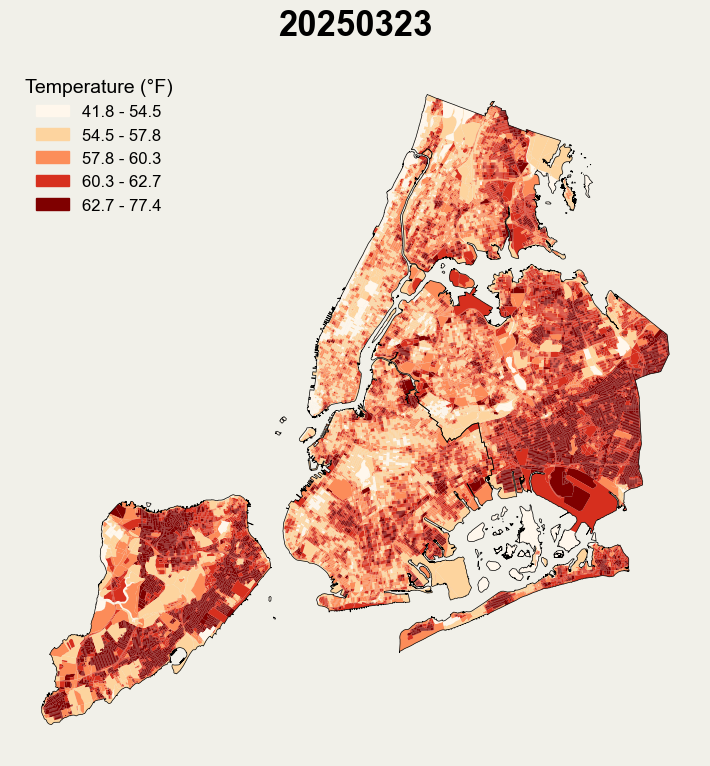

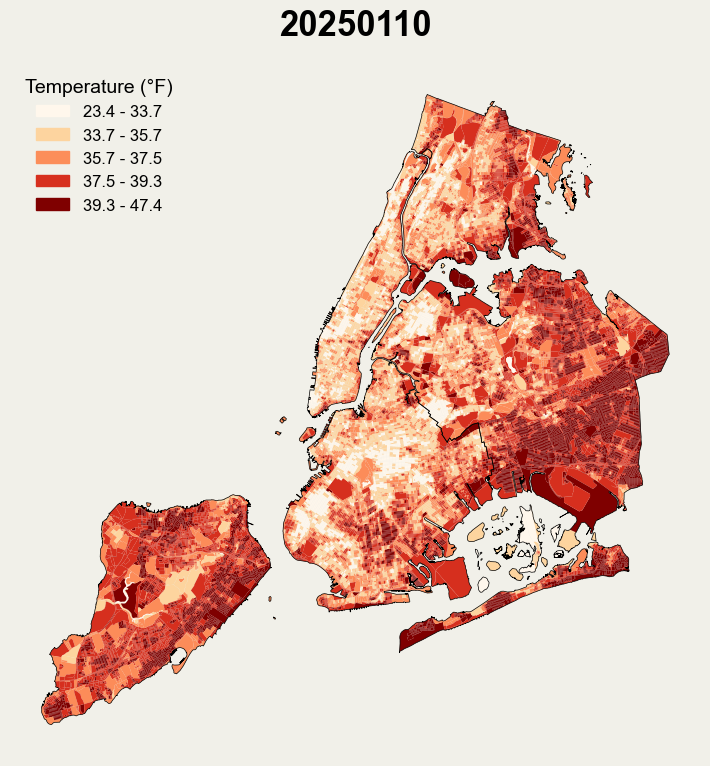

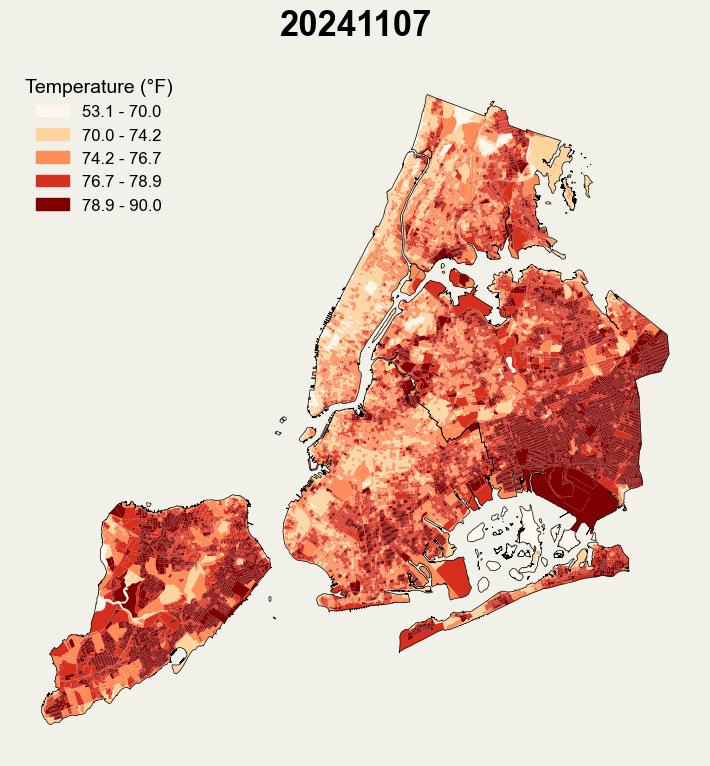

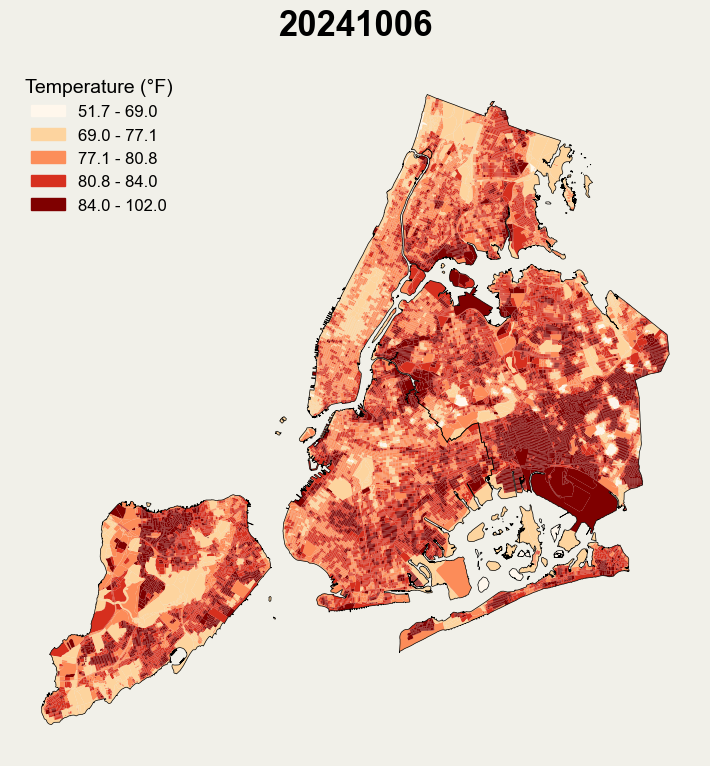

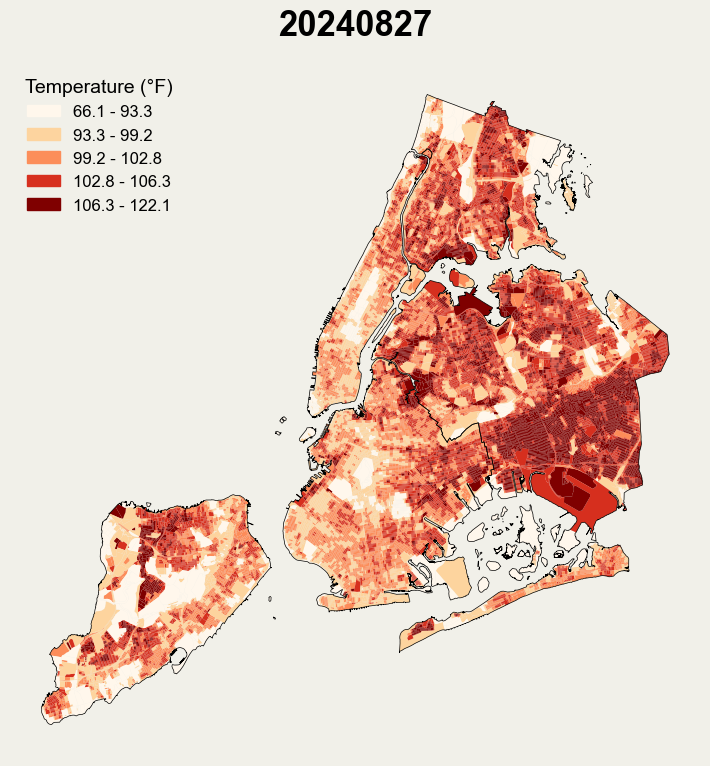

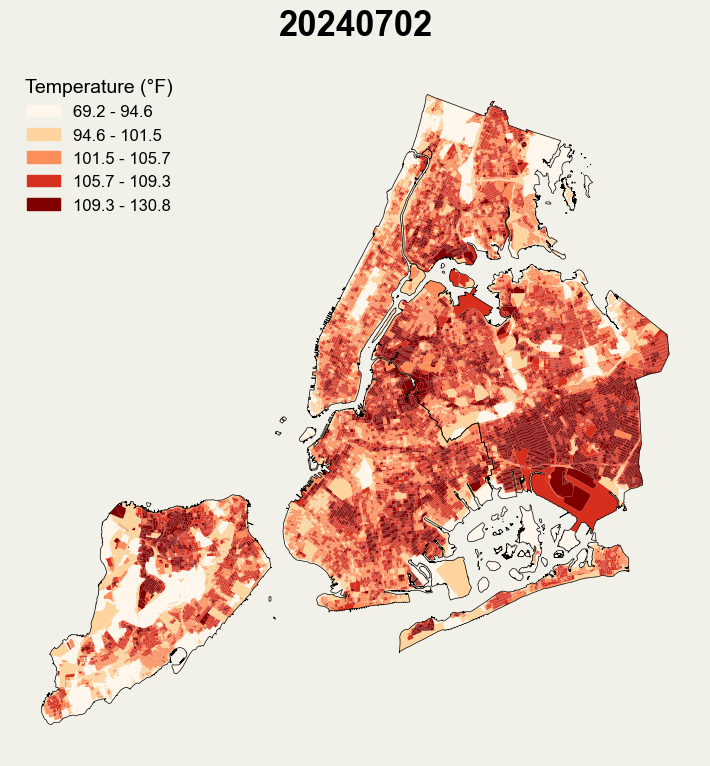

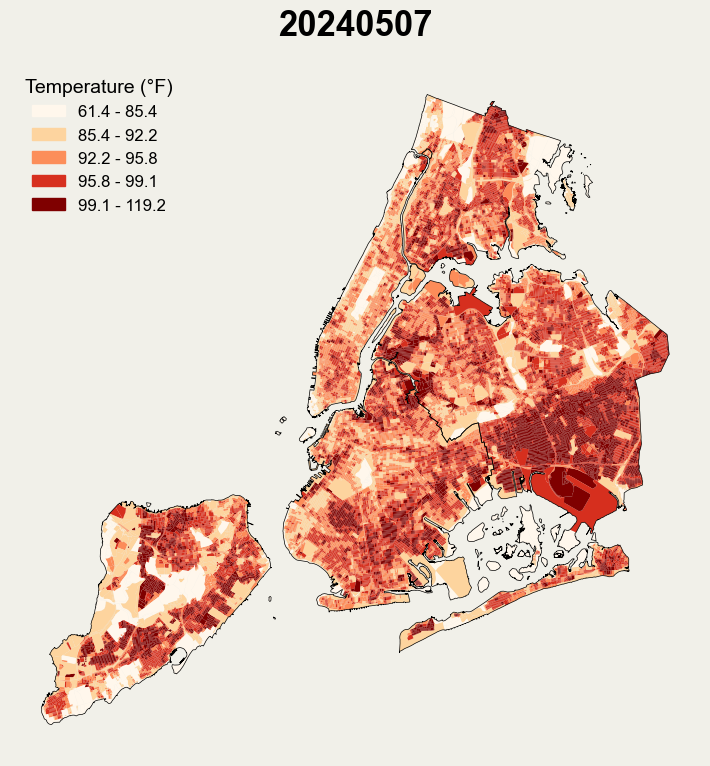

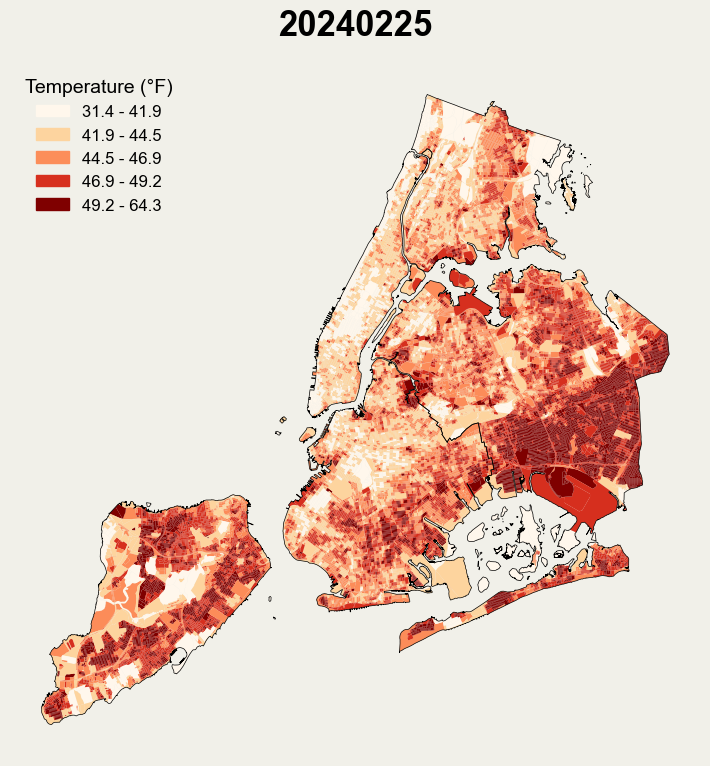

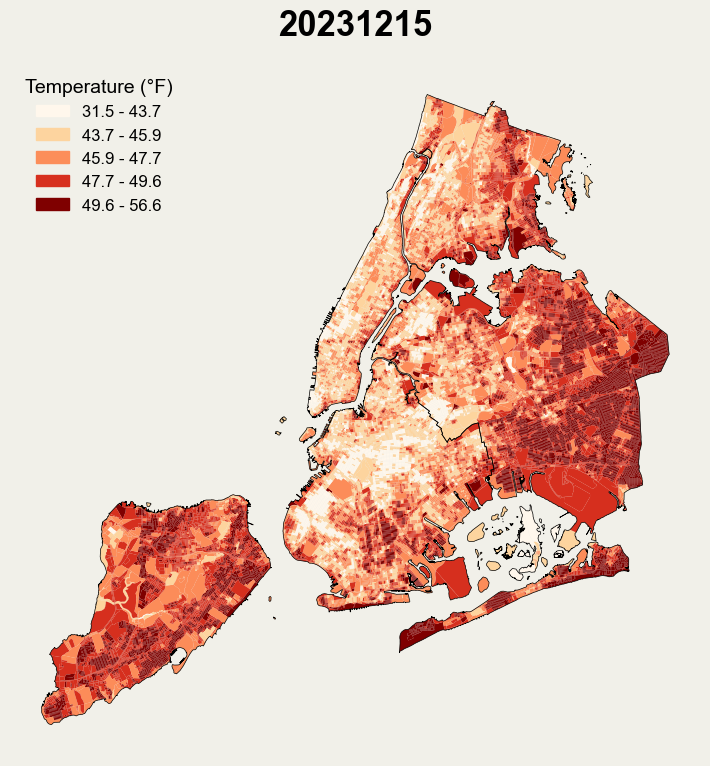

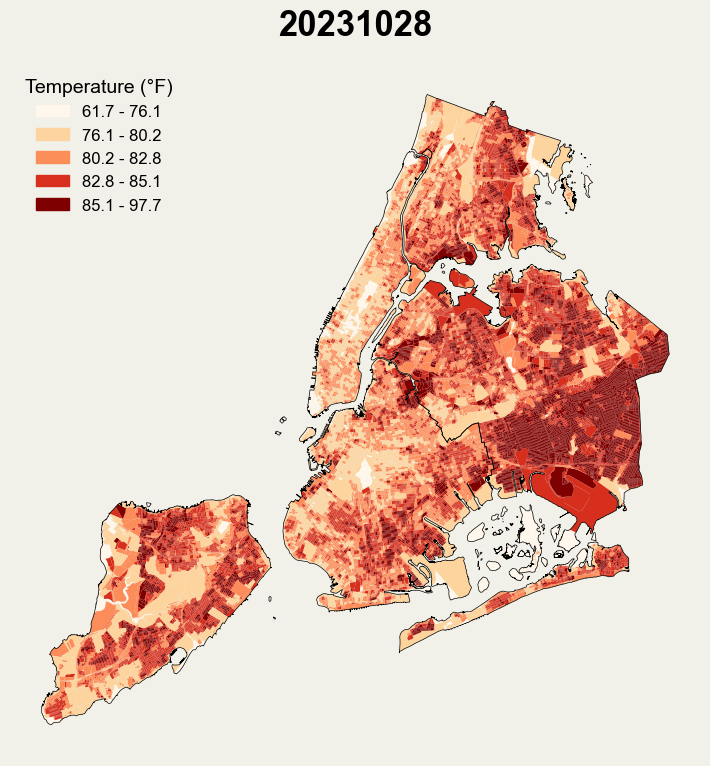

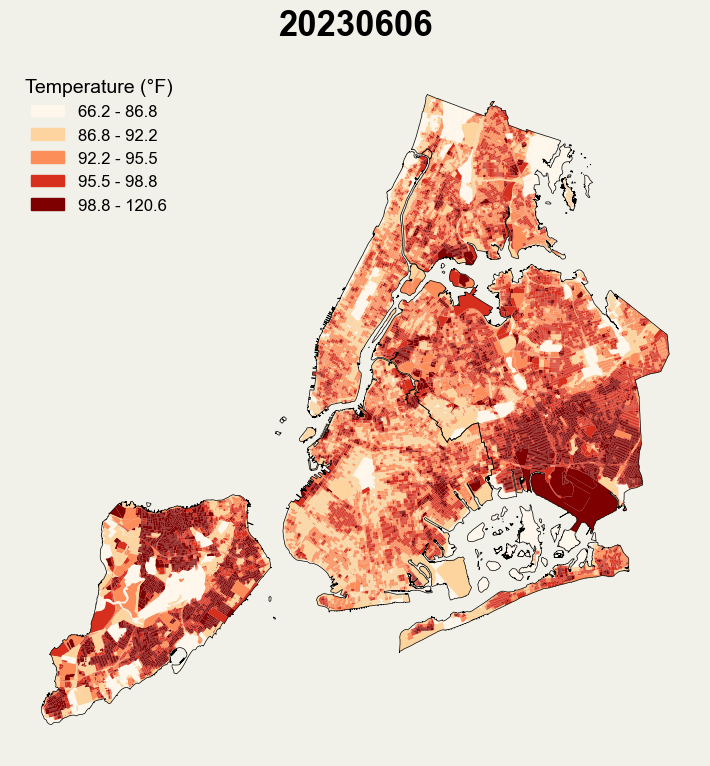

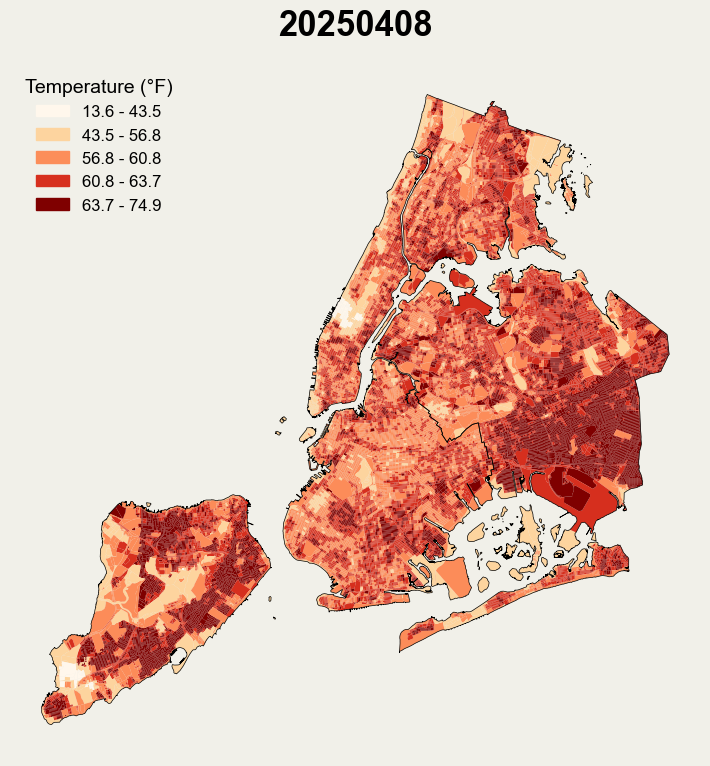

In [6]:
import geopandas as gpd
import matplotlib.pyplot as plt
import mapclassify
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches
import matplotlib.cm as cm
import matplotlib.colors as colors

file_name = ["L2SP_20250323",'L2SP_20250110','L2SP_20241107',
             'L2SP_20241006','L2SP_20240827','L2SP_20240702',
             'L2SP_20240507','L2SP_20240225','L2SP_20231215',
             'L2SP_20231028','L2SP_20230606','L2SP_20250408']
file_path = "../USGS_Raster/"

for i in file_name:
    json_file = file_path + 'Temp_data/' + i + '.geojson'
    gdf_result = gpd.read_file(json_file)
    gdf_result.dropna(subset=['temperature_F'], inplace=True)
    boundary_gdf = gpd.read_file("../USGS_Raster/Borough.geojson")
    boundary_gdf = boundary_gdf.to_crs(gdf_result.crs)

    # Using NaturalBreak to classify
    classifier = mapclassify.NaturalBreaks(gdf_result['temperature_F'], k=5)
    gdf_result['bin'] = classifier.yb
    bin_edges = [gdf_result['temperature_F'].min()] + list(classifier.bins)
    # Legend's Label
    labels = [f"{round(bin_edges[i], 1)} - {round(bin_edges[i+1], 1)}" for i in range(len(bin_edges)-1)]

    # Setting Up the plt
    plt.rcParams["font.family"] = "Arial"
    fig, ax = plt.subplots(figsize=(9, 9))
    fig.patch.set_facecolor("#F1F0E9")
    ax.set_facecolor("#F1F0E9")

    # Draw the pics
    gdf_result.plot(column='bin',cmap='OrRd',ax=ax,legend=False,edgecolor='none')
    boundary_gdf.boundary.plot(ax=ax, color='black', linewidth=0.5)
    ax.axis('off')
    title = i[5:]
    plt.title(title, fontsize=25, fontweight='bold', pad=20)

    # Adding the Legend
    cmap = plt.cm.OrRd
    norm = colors.BoundaryNorm(boundaries=bin_edges, ncolors=cmap.N)
    handles = [
        mpatches.Patch(color=cmap(norm((bin_edges[i] + bin_edges[i+1]) / 2)), label=labels[i]) 
        for i in range(len(labels))]
    ax.legend(handles=handles,title="Temperature (°F)",loc='upper left',title_fontsize=14,fontsize=12,frameon=False)

    # Save the pics
    pics_path = file_path + 'Example_Pic/' + i[5:] + '.png'
    fig.savefig(pics_path, dpi=300, facecolor='#F1F0E9')
    # plt.show()